<a href="https://colab.research.google.com/github/yashtalekar/PokemonClassifier/blob/main/PokemonClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
!pip install sklearn
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing


print(tf.__version__)

2.5.0


In [282]:
# This is to mount Google Drive to get data.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [283]:
# Now use pandas to read this data and get it into the colab notebook.
dataframe = pd.read_csv('/content/gdrive/My Drive/PokemonData/pokedex_(Update_04.21).csv')

In [284]:
# Name the first column since it has no name.
dataframe.rename( columns={'Unnamed: 0':'index_number'}, inplace=True )

In [285]:
# Drop un-used columns.
dataframe = dataframe.drop(columns=['german_name', 'japanese_name', 'generation', 'species'])
# Drop the last N columns. (if you use type effectiveness, classifying by type is trivial)
# N = 23
# dataframe = dataframe.iloc[: , :-23]

dataframe[['type_2','ability_2', 'ability_hidden', 'egg_type_1', 'egg_type_2']] = dataframe[['type_2','ability_2', 'ability_hidden', 'egg_type_1', 'egg_type_2']].fillna('') # Specific columns

In [286]:
dataframe = dataframe.drop_duplicates(subset='pokedex_number')

In [287]:
# Now that the data has been cleansed, we can classify!
# First make a target column, which contains the labels according to the following dictionary.
type_labels = {"Normal": 0, "Fighting": 1, "Flying": 2, "Poison": 3, "Ground": 4, 
               "Rock": 5, "Bug": 6, "Ghost": 7, "Steel": 8, "Fire": 9, "Water": 10, 
               "Grass": 11, "Electric": 12, "Psychic": 13, "Ice": 14, "Dragon": 15,
               "Dark": 16, "Fairy": 17}

dataframe['target'] = dataframe.apply(lambda row: type_labels[row.type_1], axis=1)


In [288]:
dataframe.head()

,index_number,pokedex_number,name,status,type_number,type_1,type_2,height_m,weight_kg,abilities_number,ability_1,ability_2,ability_hidden,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_friendship,base_experience,growth_rate,egg_type_number,egg_type_1,egg_type_2,percentage_male,egg_cycles,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fight,against_poison,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,target
0,0,1,Bulbasaur,Normal,2,Grass,Poison,0.7,6.9,2,Overgrow,,Chlorophyll,318,45,49,49,65,65,45,45.0,70.0,64.0,Medium Slow,2,Grass,Monster,87.5,20.0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,11
1,1,2,Ivysaur,Normal,2,Grass,Poison,1.0,13.0,2,Overgrow,,Chlorophyll,405,60,62,63,80,80,60,45.0,70.0,142.0,Medium Slow,2,Grass,Monster,87.5,20.0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,11
2,2,3,Venusaur,Normal,2,Grass,Poison,2.0,100.0,2,Overgrow,,Chlorophyll,525,80,82,83,100,100,80,45.0,70.0,236.0,Medium Slow,2,Grass,Monster,87.5,20.0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,11
4,4,4,Charmander,Normal,1,Fire,,0.6,8.5,2,Blaze,,Solar Power,309,39,52,43,60,50,65,45.0,70.0,62.0,Medium Slow,2,Dragon,Monster,87.5,20.0,1.0,0.5,2.0,1.0,0.50,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,9
5,5,5,Charmeleon,Normal,1,Fire,,1.1,19.0,2,Blaze,,Solar Power,405,58,64,58,80,65,80,45.0,70.0,142.0,Medium Slow,2,Dragon,Monster,87.5,20.0,1.0,0.5,2.0,1.0,0.50,0.5,1.0,1.0,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,9


In [289]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


574 train examples
144 validation examples
180 test examples


In [290]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [291]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)


In [292]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of names:', train_features['name'])
print('A batch of targets:', label_batch )



Every feature: ['index_number', 'pokedex_number', 'name', 'status', 'type_number', 'type_1', 'type_2', 'height_m', 'weight_kg', 'abilities_number', 'ability_1', 'ability_2', 'ability_hidden', 'total_points', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship', 'base_experience', 'growth_rate', 'egg_type_number', 'egg_type_1', 'egg_type_2', 'percentage_male', 'egg_cycles', 'against_normal', 'against_fire', 'against_water', 'against_electric', 'against_grass', 'against_ice', 'against_fight', 'against_poison', 'against_ground', 'against_flying', 'against_psychic', 'against_bug', 'against_rock', 'against_ghost', 'against_dragon', 'against_dark', 'against_steel', 'against_fairy']
A batch of names: tf.Tensor([b'Lunatone' b'Kecleon' b'Larvesta' b'Alomomola' b'Chimecho'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([ 5  0  6 10 13], shape=(5,), dtype=int64)


In [293]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer


hp_col = train_features['hp']
layer = get_normalization_layer('hp', train_ds)
layer(hp_col)




<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.781772  ],
       [-0.36345112],
       [-0.55432165],
       [ 3.6448298 ],
       [ 0.20916043]], dtype=float32)>

In [294]:

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [295]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['type_number', 'height_m', 'weight_kg', 'total_points', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [276]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

# Categorical features encoded as string.
categorical_cols = ['status', 'type_2', 'ability_1','ability_2', 'ability_hidden', 'egg_type_1', 'egg_type_2']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


In [277]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
output = tf.keras.layers.Dense(18, activation="softmax")(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])


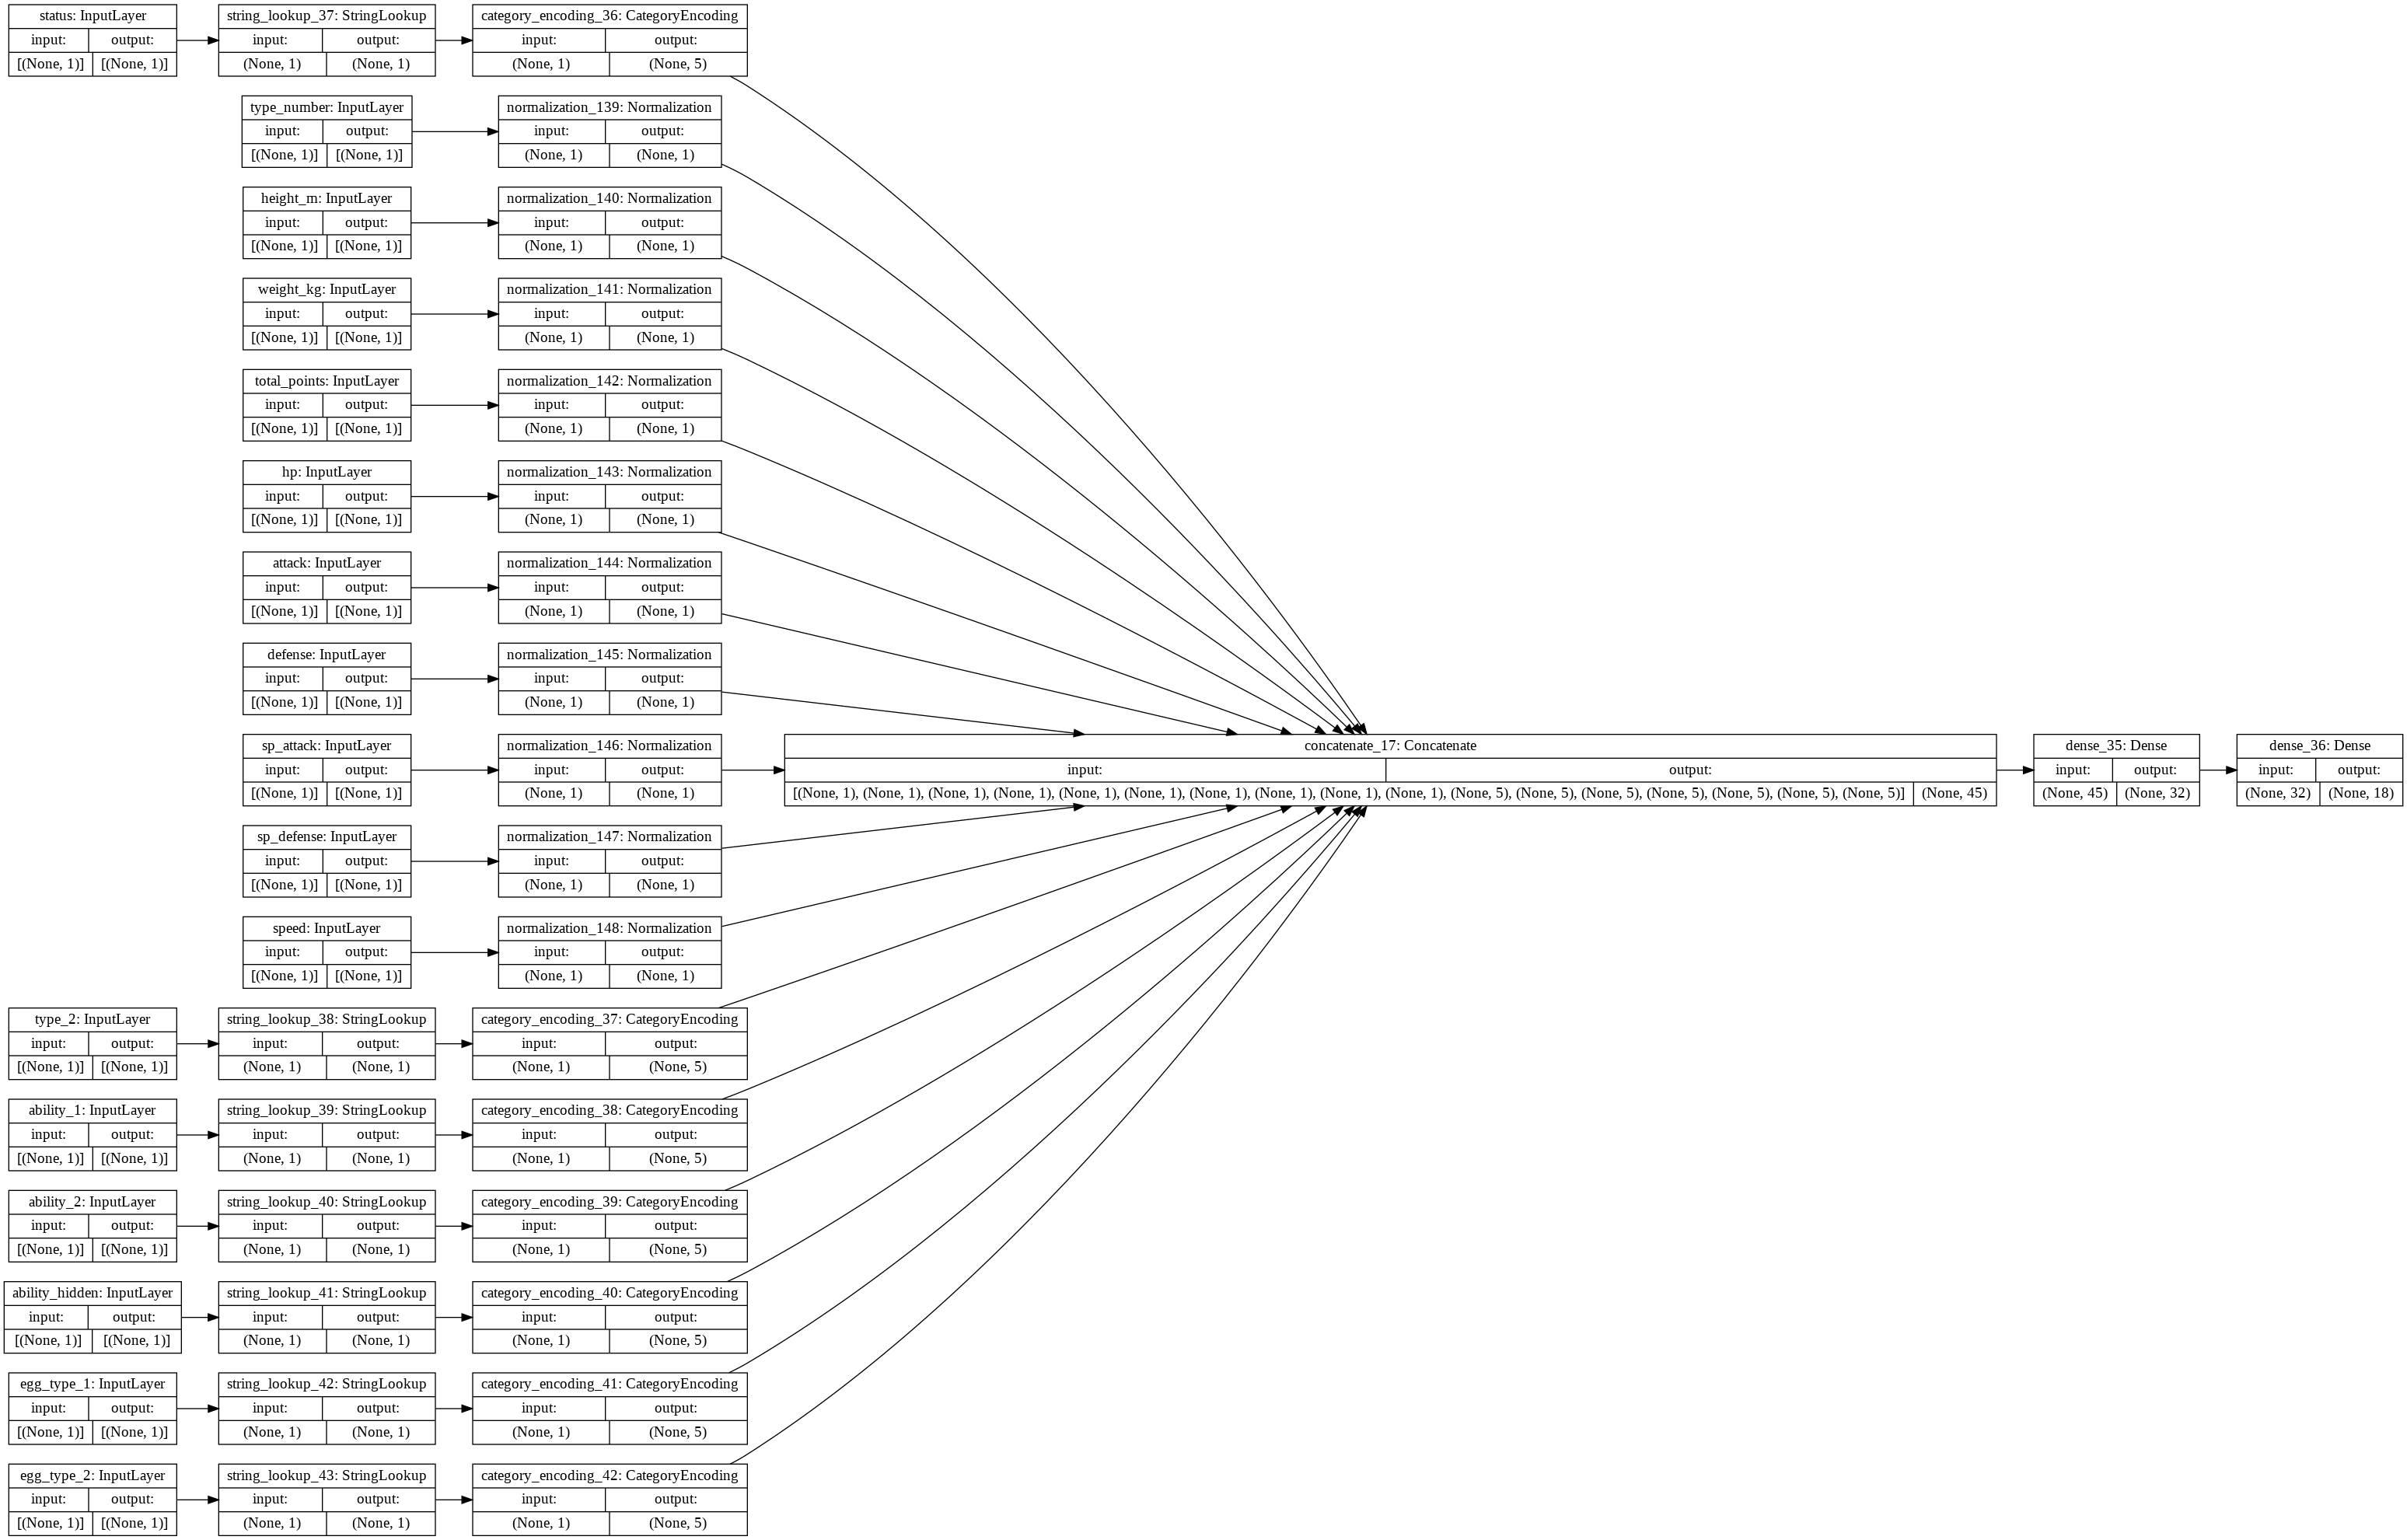

In [278]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [279]:
model.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['index_number', 'pokedex_number', 'name', 'type_1', 'abilities_number', 'catch_rate', 'base_friendship', 'base_experience', 'growth_rate', 'egg_type_number', 'percentage_male', 'egg_cycles', 'against_normal', 'against_fire', 'against_water', 'against_electric', 'against_grass', 'against_ice', 'against_fight', 'against_poison', 'against_ground', 'against_flying', 'against_psychic', 'against_bug', 'against_rock', 'against_ghost', 'against_dragon', 'against_dark', 'against_steel', 'against_fairy'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


115/115 [==============================] - 2s 9ms/step - loss: 2.8580 - accuracy: 0.1359 - val_loss: 2.7773 - val_accuracy: 0.1806
Epoch 2/50
115/115 [==============================] - 0s 4ms/step - loss: 2.5865 - accuracy: 0.2456 - val_loss: 2.6450 - val_accuracy: 0.2153
Epoch 3/50
115/115 [==============================] - 0s 4ms/step - loss: 2.3797 - accuracy: 0.3240 - val_loss: 2.5450 - val_accuracy: 0.2569
Epoch 4/50
115/115 [==============================] - 1s 4ms/step - loss: 2.2095 - accuracy: 0.3780 - val_loss: 2.4692 - val_accuracy: 0.3194
Epoch 5/50
115/115 [==============================] - 0s 4ms/step - loss: 2.0720 - accuracy: 0.4216 - val_loss: 2.4060 - val_accuracy: 0.3403
Epoch 6/50
115/115 [==============================] - 0s 4ms/step - loss: 1.9610 - accuracy: 0.4460 - val_loss: 2.3629 - val_accuracy: 0.3750
Epoch 7/50
115/115 [==============================] - 1s 5ms/step - loss: 1.8585 - accuracy: 0.4756 - val_loss: 2.3087 - val_accuracy: 0.4028
Epoch 8/50
115/11

In [280]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

36/36 [==============================] - 0s 3ms/step - loss: 2.1836 - accuracy: 0.4333
Accuracy 0.4333333373069763
